In [55]:
import pandas as pd
import os 
import xml.etree.ElementTree as ET
from PIL import Image, ImageOps
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import resnet50  # Import the ResNet50 model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [56]:
cropped_folder = 'resources/stanford-dogs-dataset/cropped-images'

In [57]:
# Custom preprocessing function to ensure images are in RGB format
def ensure_rgb(image):
    # Check if image is grayscale (only 1 channel)
    if image.ndim == 3 and image.shape[2] == 1:
        # Convert grayscale to RGB by repeating the single channel 3 times
        image = np.repeat(image, 3, axis=-1)
    elif image.ndim == 2:
        # If image is 2D (grayscale), expand dimensions and repeat across 3 channels
        image = np.expand_dims(image, axis=-1)
        image = np.repeat(image, 3, axis=-1)
    return image

In [ ]:
# Define normalization and augmentation
datagen = ImageDataGenerator(
    preprocessing_function=lambda x: resnet50.preprocess_input(ensure_rgb(x)),  # Ensure RGB and apply ResNet50 preprocessing
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.5],
    fill_mode='nearest'
)

# Apply transformations to dataset
train_generator = datagen.flow_from_directory(
    cropped_folder,  # Provide your folder path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 20579 images belonging to 120 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


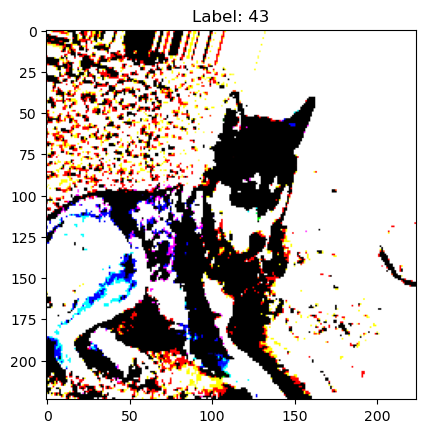

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


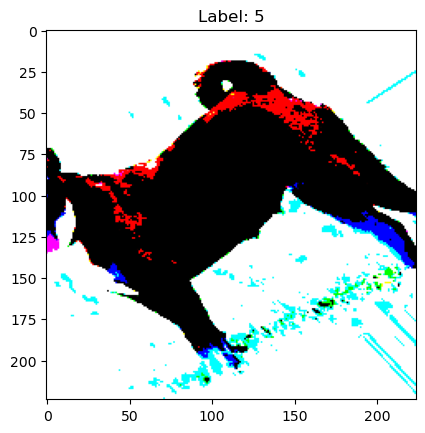

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


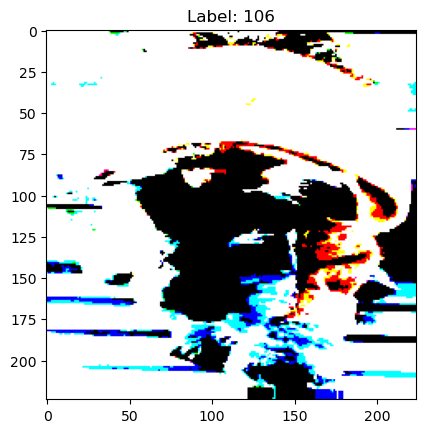

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


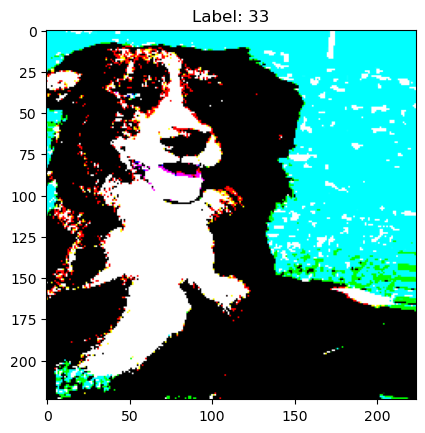

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


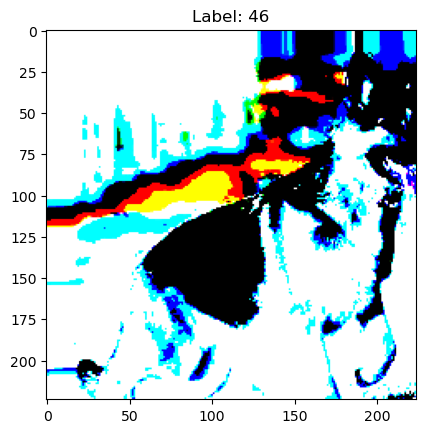

In [59]:
# Get a sample batch (for example, the first batch)
images, labels = next(train_generator)

# Plot the first 5 images from the batch
for i in range(5):
    plt.imshow(images[i])  # Display image
    plt.title(f"Label: {np.argmax(labels[i])}")  # Display corresponding label
    plt.show()

In [60]:
def resize_with_padding(image, target_size=(224, 224)):
    """Resize an image while keeping aspect ratio and adding padding."""
    image = np.array(image)  # Ensure it's a NumPy array
    image = (image * 255).astype(np.uint8)  # Convert to uint8

    img = Image.fromarray(image)  # Convert to PIL Image
    img = ImageOps.fit(img, target_size, method=Image.Resampling.LANCZOS, centering=(0.5, 0.5))

    return np.array(img)  # Convert back to NumPy array

In [61]:
batch_images, batch_labels = next(train_generator)

print(f"Image batch shape: {batch_images.shape}")  # Should be (batch_size, 128, 128, 3)
print(f"Label batch shape: {batch_labels.shape}")  # Should match the number of classes
print(f"Pixel range: min={batch_images.min()}, max={batch_images.max()}")  # Should be between 0 and 1


Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 120)
Pixel range: min=-123.68000030517578, max=151.06100463867188


In [62]:
datagen = ImageDataGenerator(
    preprocessing_function=resnet50.preprocess_input,
    validation_split=0.2  # 20% validation
)

train_generator = datagen.flow_from_directory(
    cropped_folder,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    cropped_folder,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)


Found 16507 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [63]:
# Load MobileNet without the top (fully connected layers) to use it as a feature extractor
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top for your specific task (dog breeds classification)
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),  # Add Dropout layer with 50% dropout rate
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Another Dropout layer to prevent overfitting
    layers.Dense(120, activation='softmax')  # Adjust this to your number of dog breeds
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping callback: stop training if the validation loss does not improve for 5 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Summary of the model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 120)            │        61,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,698,360 (94.22 MB)

 Trainable params: 1,110,648 (4.24 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Training the model with early stopping
history = model.fit(
    train_generator,  # Your training dataset
    epochs=20,   # You can choose a higher number of epochs
    validation_data=val_generator,  # Your validation dataset
    callbacks=[early_stopping]  # Pass the early stopping callback
)

Epoch 1/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 973s 4s/step - accuracy: 0.1950 - loss: 3.7952 - val_accuracy: 0.7291 - val_loss: 0.9455
Epoch 2/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 909s 4s/step - accuracy: 0.5914 - loss: 1.4218 - val_accuracy: 0.7741 - val_loss: 0.7564
Epoch 3/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 39516s 154s/step - accuracy: 0.6625 - loss: 1.1291 - val_accuracy: 0.7800 - val_loss: 0.7041
Epoch 4/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 937s 4s/step - accuracy: 0.6967 - loss: 1.0093 - val_accuracy: 0.7873 - val_loss: 0.6798
Epoch 5/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 990s 4s/step - accuracy: 0.7107 - loss: 0.9328 - val_accuracy: 0.7930 - val_loss: 0.6728
Epoch 6/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 964s 4s/step - accuracy: 0.7216 - loss: 0.9024 - val_accuracy: 0.7957 - val_loss: 0.6676
Epoch 7/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 1039s 4s/step - accuracy: 0.7388 - loss: 0.8336 - val_accuracy: 0.8003 - val_loss: 0.6705
Epoch 8/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 1269s 5s/step - accuracy: 0.7423 - loss: 0.8230 - va

In [65]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

model.save("dog_breed_classifier.h5")

64/64 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.8004 - loss: 0.6509


Validation Accuracy: 80.70%
